In [1]:
import numpy as np

from IPython.display import clear_output
from matplotlib import pyplot as plt
import scipy.interpolate

from timeit import default_timer as timer
from datetime import timedelta

import math
import random
import copy

from qutip import Bloch, Bloch3d, basis
from qutip.qip.operations import rx, rz

from qutip.operators import sigmax, sigmay, sigmaz
from qutip.qip.operations import snot
from qutip import basis, expect

# Local imports
from spectator_env_v2 import SpectatorEnvContinuousV2

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Since we are preparing |+>, it useful to parameterize all unitaries
# considered in this algorithm in terms of their image on this state.
# The classic cos(\theta) |+> + e^(i\phi) |-> representation is used
def extract_theta_phi(single_qubit_gate):
    # apply gate to |+>
    ket = single_qubit_gate * snot() * basis(2, 0)

    alpha = ket.full()[0][0]
    beta = ket.full()[1][0]
    # rewrite in x-basis
    ket_raw = [(alpha + beta) / 2, (alpha - beta) / 2]
    ket_raw = ket_raw / np.linalg.norm(ket_raw)

    theta = 0
    phi = 0

    if ket_raw[0] * ket_raw[0].conj() < 1e-6:
        theta = np.pi
        phi = 0
    elif ket_raw[1] * ket_raw[1].conj() < 1e-6:
        theta = 0
        phi = 0
    else:
        theta = 2 * np.arccos(np.sqrt(ket_raw[0] * ket_raw[0].conj()))
        phi = np.angle(ket_raw[0].conj() * ket_raw[1] / (
            np.sqrt(ket_raw[0] * ket_raw[0].conj()) * np.sqrt(ket_raw[1] * ket_raw[1].conj())))

    return theta, phi

In [4]:
def context_loss(meas, trans):
    return np.var([np.pi - np.arccos(
        np.sqrt(t.overlap(meas) * meas.overlap(t))) for t in trans])


def correction_loss(meas, trans):
    return np.mean([np.pi - np.arccos(
        np.sqrt(t.overlap(meas) * meas.overlap(t))) for t in trans])


# This is the contour of the "true loss" for correction and contextualization.
def get_contour(error_samples, loss_fn):
    prepared_basis = [snot() * basis(2, 0), snot() * sigmax() * basis(2, 0)]
    trans = [rz(sample) * prepared_basis[0] for sample in error_samples]

    thetas = np.linspace(-np.pi, np.pi, 33)
    phis = np.linspace(-np.pi, np.pi, 33)
    loss = np.zeros((len(thetas), len(phis)))

    min_phi = 0.
    min_theta = 0.
    min_loss = 1.

    max_phi = 0.
    max_theta = 0.
    max_loss = 0.
    for i, theta in enumerate(thetas):
        for j, phi in enumerate(phis):
            meas = np.cos(theta / 2) * prepared_basis[0] + np.exp(
                1j * phi) * np.sin(theta / 2) * prepared_basis[1]
            meas = meas.unit()

            objective = loss_fn(meas, trans)
            if (np.abs(objective) < min_loss):
                min_loss = objective
                min_phi = phi
                min_theta = theta
            if (np.abs(objective) > max_loss):
                max_loss = objective
                max_phi = phi
                max_theta = theta
            loss[i][j] = np.abs(objective)
    return {'thetas': thetas, 'phis': phis, 'loss': loss,
            'max_phi': max_phi, 'max_theta': max_theta}

In [5]:
def analytic_context_grad(meas_lo, meas_mid, meas_hi, trans):
    lo = np.array([np.sqrt(t.overlap(meas_lo) * meas_lo.overlap(t)) for t in trans])
    mid = np.array([np.sqrt(t.overlap(meas_mid) * meas_mid.overlap(t)) for t in trans])
    hi = np.array([np.sqrt(t.overlap(meas_hi) * meas_hi.overlap(t)) for t in trans])

    mean_mid = np.mean(mid)
    mean_lo = np.mean(lo)
    mean_hi = np.mean(hi)
    var_grad = np.mean([2 * (m - mean_mid) * ((h - l) - (mean_hi - mean_lo))
                        for l, m, h in zip(lo, mid, hi)])
    return var_grad

# This is the contour of the *gradient* we actually compute using parameter-shift-measurable
# observables. Spectator qubits achieve a finite sampling of this expectation value.
def get_analytic_contour(error_samples, num_variational_params=11):
    prepared_basis = [snot() * basis(2, 0), snot() * sigmax() * basis(2, 0)]
    trans = [rz(sample) * prepared_basis[0] for sample in error_samples]

    variational_params = np.linspace(-np.pi, np.pi - (np.pi/128), num_variational_params)
    theta_phi_feedback = {}

    for t_1 in variational_params:
        for t_2 in variational_params:
            for t_3 in variational_params:
                t = [t_1, t_2, t_3]
                unitary_mid = rz(t[2]) * rx(-np.pi/2) * rz(t[1]) * rx(np.pi / 2) * rz(t[0])
                
                theta_mid, phi_mid = extract_theta_phi(unitary_mid.dag())
                meas_mid = (np.cos(theta_mid / 2) * prepared_basis[0] + np.exp(
                    1j * phi_mid) * np.sin(theta_mid / 2) * prepared_basis[1]).unit()
                
                if (theta_mid, phi_mid) in theta_phi_feedback.keys():
                    continue
                
                g = []
                for i in range(3):
                    t[i] += -np.pi / 2
                    unitary_lo = (rz(t[2]) * rx(-np.pi/2) * rz(t[1]) * rx(np.pi / 2) * rz(t[0]))
                    t[i] += np.pi
                    unitary_hi = (rz(t[2]) * rx(-np.pi/2) * rz(t[1]) * rx(np.pi / 2) * rz(t[0]))
                    t[i] += -np.pi / 2

                    theta_lo, phi_lo = extract_theta_phi(unitary_lo.dag())
                    theta_hi, phi_hi = extract_theta_phi(unitary_hi.dag())
                
                    meas_lo = (np.cos(theta_lo / 2) * prepared_basis[0] + np.exp(
                        1j * phi_lo) * np.sin(theta_lo / 2) * prepared_basis[1]).unit()
                    meas_hi = (np.cos(theta_hi / 2) * prepared_basis[0] + np.exp(
                        1j * phi_hi) * np.sin(theta_hi / 2) * prepared_basis[1]).unit()

                    g.append(analytic_context_grad(meas_lo=meas_lo, meas_mid=meas_mid, meas_hi=meas_hi, trans=trans))
                
                theta_phi_feedback[(round(theta_mid,2), round(phi_mid, 2))] = np.linalg.norm(g)
    
    theta_grid = []
    phi_grid = []
    feedback = []
    
    for (t, p), f in theta_phi_feedback.items():
        theta_grid.append(t)
        phi_grid.append(p)
        feedback.append(f)
    theta_grid = np.array(theta_grid)
    phi_grid = np.array(phi_grid)
    mesh_theta = mesh_phi = np.linspace(-np.pi, np.pi, len(variational_params ** 3))
    mesh_theta, mesh_phi = np.meshgrid(mesh_theta, mesh_phi)

    # Interpolate using radial basis kernel.
    rbf = scipy.interpolate.Rbf(theta_grid, phi_grid, feedback, function='linear')
    loss = rbf(mesh_theta, mesh_phi)

    return {'mesh_phi': mesh_phi, 'mesh_theta': mesh_theta, 'loss': loss}

In [6]:
def set_up_plots():
    _, axs = plt.subplots(1, 2, figsize=(15, 10),
                              subplot_kw=dict(polar=True))
    _, axs_context_contour = plt.subplots(1, 1, figsize=(7.5, 7.5),
                                          subplot_kw=dict(polar=True))
    _, axs_correction_contour = plt.subplots(1, 2, figsize=(15, 10),
                                             subplot_kw=dict(polar=True))
    _, ax_fid = plt.subplots(1, 1, figsize=(7.5, 5))
    _, ax_hist = plt.subplots(1, 2, figsize=(15, 7.5))
    _, axs_correction_grad = plt.subplots(1, 2, figsize=(15, 10))
    _, ax_context_grad = plt.subplots(1, 1, figsize=(7.5, 5))
    
    return np.concatenate((axs, [axs_context_contour], axs_correction_contour,
                             [ax_fid], ax_hist, axs_correction_grad, [ax_context_grad]))
        
        
def plot(frame_idx, elapsed_time, baseline_fidelity=None,
         corrected_fidelity=None,  context_theta_history=None,
         correction_theta_history=None, context_outcome_hist=None,
         context_contour=None, correction_contour=None, correction_grads=None,
        context_grads=None):
    
    axs = set_up_plots()

    if correction_theta_history:
        axs[0].set_title('Correction phase space (gradient steps)')
        for k, v in correction_theta_history.items():
            alphas = np.linspace(0.1, 1, len(v))
            rgba_colors = np.zeros((len(v), 4))
            rgba_colors[:, 1] = 1 - k
            rgba_colors[:, 2] = k
            rgba_colors[:, 3] = alphas
            axs[0].scatter([x[1] for x in v], [x[0] for x in v], c=rgba_colors,
                           label=k)

        axs[0].legend()

    if context_theta_history:
        alphas = np.linspace(0.1, 1, len(context_theta_history))
        rgba_colors = np.zeros((len(context_theta_history), 4))
        rgba_colors[:, 2] = 1.0
        rgba_colors[:, 3] = alphas

        axs[1].set_title('Context phase space (gradient steps)')
        axs[1].scatter([x[1] for x in context_theta_history],
                       [x[0] for x in context_theta_history], c=rgba_colors)

    if context_contour and context_theta_history:
        thetas = context_contour['thetas']
        phis = context_contour['phis']
        loss = context_contour['loss']
        r, theta = np.meshgrid(len(thetas), len(phis))
        axs[2].contourf(phis, thetas, loss, alpha=0.5)

        alphas = np.linspace(0.1, 1, len(context_theta_history))
        rgba_colors = np.zeros((len(context_theta_history), 4))
        rgba_colors[:, 2] = 1.0
        rgba_colors[:, 3] = alphas

        axs[2].set_title('Context phase space (gradient steps)')
        axs[2].scatter([x[1] for x in context_theta_history],
                       [x[0] for x in context_theta_history], c=rgba_colors)

    if correction_contour and correction_theta_history:
        thetas = correction_contour[0]['thetas']
        phis = correction_contour[0]['phis']
        loss = correction_contour[0]['loss']
        r, theta = np.meshgrid(len(thetas), len(phis))
        axs[3].contourf(phis, thetas, loss, alpha=0.5)

        axs[3].set_title('Context 0: Correction phase space (gradient steps)')
        alphas = np.linspace(0.1, 1, len(v))
        rgba_colors = np.zeros((len(v), 4))
        rgba_colors[:, 2] = 1
        rgba_colors[:, 3] = alphas
        axs[3].scatter([x[1] for x in correction_theta_history[0]],
                       [x[0] for x in correction_theta_history[0]],
                       c=rgba_colors)

        thetas = correction_contour[1]['thetas']
        phis = correction_contour[1]['phis']
        loss = correction_contour[1]['loss']
        r, theta = np.meshgrid(len(thetas), len(phis))
        axs[4].contourf(phis, thetas, loss, alpha=0.5)

        axs[4].set_title('Context 1: Correction phase space (gradient steps)')
        alphas = np.linspace(0.1, 1, len(v))
        rgba_colors = np.zeros((len(v), 4))
        rgba_colors[:, 2] = 1
        rgba_colors[:, 3] = alphas
        axs[4].scatter([x[1] for x in correction_theta_history[1]],
                       [x[0] for x in correction_theta_history[1]],
                       c=rgba_colors)

    if baseline_fidelity and corrected_fidelity:
        axs[5].set_title('Fidelity (per episode)')
        axs[5].plot(corrected_fidelity, 'g', label='corrected')
        axs[5].plot(baseline_fidelity, 'r', label='uncorrected')
        axs[5].legend()

    if context_outcome_hist:
        max_k = 0
        for k, v in context_outcome_hist.items():
            axs[6].hist(v, label=k)
            max_k = max(k, max_k)
        axs[6].set_title('Distribution of contextual outcomes (all episodes)')

        axs[7].set_title('Distribution of contextual outcomes (most recent episode)')
        axs[7].hist(context_outcome_hist[max_k])

    if correction_grads:
        axs[8].plot([g[0] for g in correction_grads[0]], label='theta_1')
        axs[8].plot([g[1] for g in correction_grads[0]], label='theta_2')
        axs[8].plot([g[2] for g in correction_grads[0]], label='theta_3')
        axs[8].set_title('Context 0: Correction gradient')
        axs[8].legend()

        axs[9].plot([g[0] for g in correction_grads[1]], label='theta_1')
        axs[9].plot([g[1] for g in correction_grads[1]], label='theta_2')
        axs[9].plot([g[2] for g in correction_grads[1]], label='theta_3')
        axs[9].set_title('Context 1: Correction gradient')
        axs[9].legend()
        
    axs[10].plot([g[0] for g in context_grads], label='theta_1')
    axs[10].plot([g[1] for g in context_grads], label='theta_2')
    axs[10].plot([g[2] for g in context_grads], label='theta_3')
    axs[10].set_title('Context gradient')
    axs[10].legend()

In [7]:
# (action, reward) distribution for a given "spectator measurement outcome" state
class Context:
    def __init__(self, gamma, eta, correction_theta_init):
        # Discount factor.
        # This parameter is deprecated given that we rely on gradient updates
        # to adjust to non-stationarity.
        self.gamma = gamma
        # Gradient step size.
        self.eta = eta

        # Feedback which is batched until we decide to use it.
        self.batch_correction_feedback = ([], [], [])
        self.correction_theta = correction_theta_init

        self.grads = [0, 0, 0]

    def reset(self):
        self.batch_correction_feedback = ([], [], [])

    def discount(self):
        pass

    def update_gamma(self, gamma):
        self.gamma = gamma

    def update_batch_feedback(self, correction_feedback, idx):
        self.batch_correction_feedback[idx].append(correction_feedback)

    def combine_correction_feedback(self):
        # feedback is given per variational param
        for idx, f in enumerate(self.batch_correction_feedback):
            lo = np.array([r[0] for r in f])
            hi = np.array([r[2] for r in f])
            lo = np.array(list(map(lambda x: -1 if x == 0 else 1, lo.flatten())))
            hi = np.array(list(map(lambda x: -1 if x == 0 else 1, hi.flatten())))

            mu_plus = np.mean(hi)
            mu_minus = np.mean(lo)

            grad = mu_plus - mu_minus

            self.correction_theta[idx] -= self.eta * grad
            self.grads[idx] = grad

        self.reset()

    def get_optimal_params(self):
        return self.correction_theta, self.grads

In [18]:
# Contextual analytic geometric descent
class Analytic2D:
    def __init__(self, env, initial_gamma=1.0, context_eta=np.pi/64,
                 correction_eta=np.pi/64, context_theta_init=[0, 0, 0],
                 correction_theta_init=[[0, 0, 0], [0, 0, 0]]):
        # Contexts are defined in terms of a function on spectator outcomes.
        # Each context learns an optimal correction independently.
        self.contexts = [Context(initial_gamma, correction_eta,
                                 correction_theta_init[0]),
                         Context(initial_gamma, correction_eta,
                                 correction_theta_init[1])]

        self.rewards = []
        self.fidelity = []
        self.control_fidelity = []

        self.num_context_spectators = env.num_context_spectators
        self.num_reward_spectators = env.num_reward_spectators

        # step size
        self.eta = context_eta

        self.batch_context_feedback = ([], [], [])
        self.context_theta = context_theta_init
        
        self.grads = [0, 0, 0]

    def get_actions(self, observations=None, batch_size=1):
        # Our context is an array of binary spectator qubit measurements.
        # Hence, we could convert this binary array to an integer and index
        # 2^(spectator qubits) contexts.
        # For now, we only have two contexts (+ vs -), and so we consider
        # spectators to be indistinguishable noise polling devices.
        # In the future, we may consider noise gradients and so we do indeed
        # need to track the specific arrangement.

        if observations is None:
            return [{'context': self.context_theta} for i in range(batch_size)]

        actions = []
        for observation in observations:
            context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
            context = self.contexts[context_idx]

            optimal_correction, correction_grad = context.get_optimal_params()
            actions.append(
                {'correction': optimal_correction,
                 'correction_grad': correction_grad,
                 'context_grad': self.grads,
                 'context': self.context_theta})
        return actions
    
    def combine_correction_feedback(self):
        for context in self.contexts:
            context.combine_correction_feedback()
    
    def combine_contextual_feedback(self):
        # Feedback is given per gate parameter.
        for idx, f in enumerate(self.batch_context_feedback):
            lo = np.array([r[0] for r in f])
            mid = np.array([r[1] for r in f])
            hi = np.array([r[2] for r in f])

            lo = np.array(list(map(lambda x: -1 if x == 0 else 1, lo.flatten())))
            mid = np.array(list(map(lambda x: -1 if x == 0 else 1, mid.flatten())))
            hi = np.array(list(map(lambda x: -1 if x == 0 else 1, hi.flatten())))

            mean_mid = np.mean(mid)
            mean_lo = np.mean(lo)
            mean_hi = np.mean(hi)
            var_grad = np.mean([2 * (m - mean_mid) * ((h - l) - (mean_hi - mean_lo))
                                for l, m, h in zip(lo, mid, hi)])
            self.grads[idx] = var_grad

            self.context_theta[idx] += self.eta * var_grad
        self.reset()

    def reset(self):
        self.batch_context_feedback = ([], [], [])

    def update_correction_feedback(self, correction_feedback, observations):
        # Feedback is given per variational param.
        for idx in range(len(self.context_theta)):
            for _correction_feedback, observation in zip(
                    correction_feedback[idx], observations):
                context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
                context = self.contexts[context_idx]
                context.update_batch_feedback(_correction_feedback, idx)

    def update_context_feedback(self, context_feedback, observations):
        # Feedback is given per variational param.
        for idx in range(len(self.context_theta)):
            for _context_feedback, observation in zip(
                    context_feedback[idx], observations):
                self.batch_context_feedback[idx].append(_context_feedback)
                
    def _update_gammas(self, gamma):
        for context in self.contexts:
            context.update_gamma(gamma)

    def save_reward(self, reward):
        self.rewards.append(reward)

    def save_fidelity(self, fidelity):
        self.fidelity.append(fidelity)

    def save_control_fidelity(self, fidelity):
        self.control_fidelity.append(fidelity)

In [19]:
# Hyperparameters

M = 100
BATCH_SIZE = 100

# Number of epochs to run simulation.
NUM_EPOCHS = 100
# (M // BATCH_SIZE) is the number of batches per epoch.
MAX_FRAMES = NUM_EPOCHS * M // BATCH_SIZE

# Redraw error samples from potentially shifted distribution.
NUM_EPOCHS_TO_REDRAW_ERRORS = 1
UPDATE_ERROR_SAMPLES_FRAMES = NUM_EPOCHS_TO_REDRAW_ERRORS * (M // BATCH_SIZE)

# Error distribution.
# May add some random harmonics
# time_dependent_fn = np.vectorize(lambda x: (2/5) * np.pi * np.sin(2 * np.pi * x / M))
MU = np.pi / 16
SIGMA = np.pi / 4
error_samples = np.random.normal(MU, SIGMA, M) # + time_dependent_fn(np.arange(M))
# error_samples = np.random.choice([-np.pi/2, np.pi / 2], M)
# error_samples = np.random.uniform(-np.pi/2, np.pi/2, M)

# Gradient steps sizes.
CONTEXT_ETA = np.pi / 8
CORRECTION_ETA = np.pi / 8

# Initialization of U3 Gates.
CONTEXT_THETA_INIT = [0, 0, 0]
CORRECTION_THETA_INIT = [[0, 0, 0], [0, 0, 0]]

NUM_CONTEXT_SPECTATORS = 36
NUM_REWARD_SPECTATORS = 36

CONTEXT_SENSITIVITY = 1.0
CORRECTION_SENSITIVITY = 1.0

In [20]:
# describes MDP
# - states are given in terms of a #context_spectators bit measurement outcomes.
# - continuous action space is given by [-pi, pi]^3 single-qubit gate parameterization.
env = SpectatorEnvContinuousV2(error_samples, batch_size=BATCH_SIZE,
                               num_context_spectators=NUM_CONTEXT_SPECTATORS,
                               num_reward_spectators=NUM_REWARD_SPECTATORS,
                               context_sensitivity=CONTEXT_SENSITIVITY,
                               reward_sensitivity=CORRECTION_SENSITIVITY)

###### TODOs

* ability to schedule contextual updates and reward updates independently
* \>2 contexts, potentially with structure imposed
* fix sensitivity
* outer loop plots

In [21]:
context_contour = get_contour(error_samples, context_loss)
print(context_contour['max_phi'], context_contour['max_theta'])

-1.5707963267948966 -1.5707963267948966


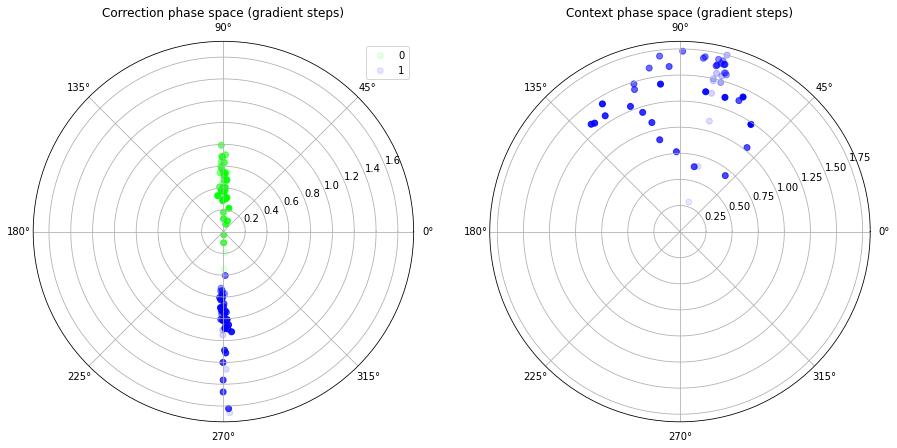

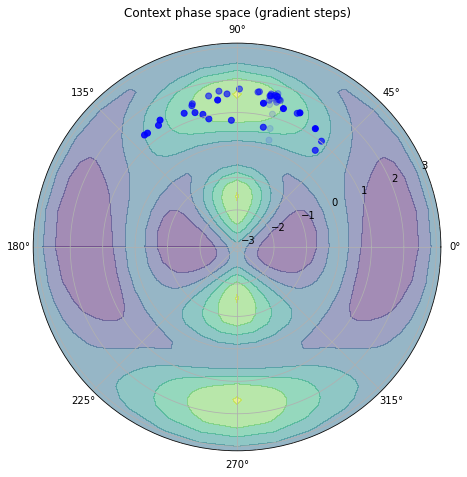

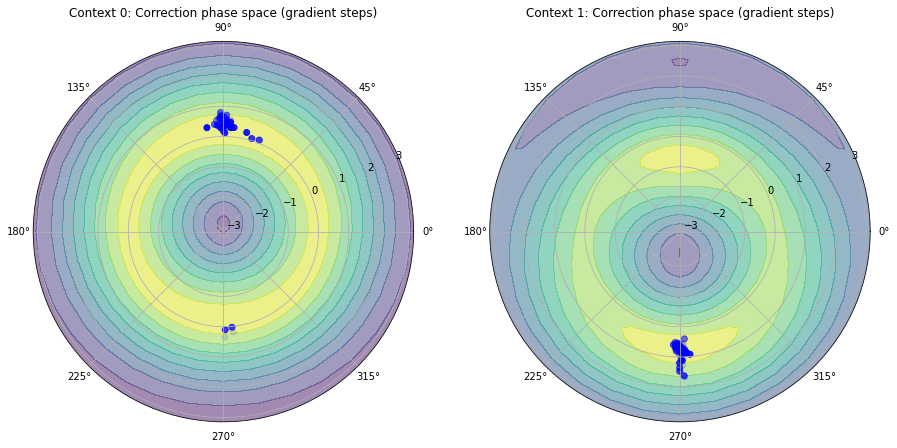

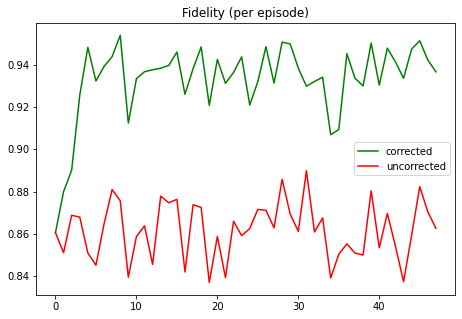

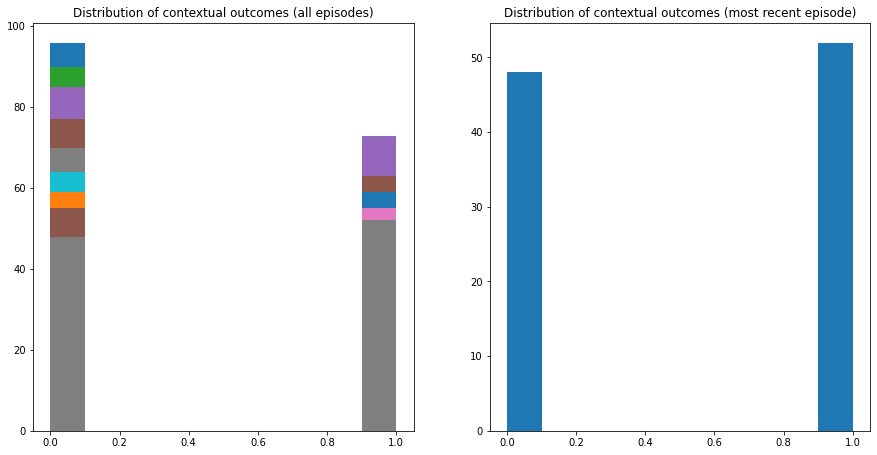

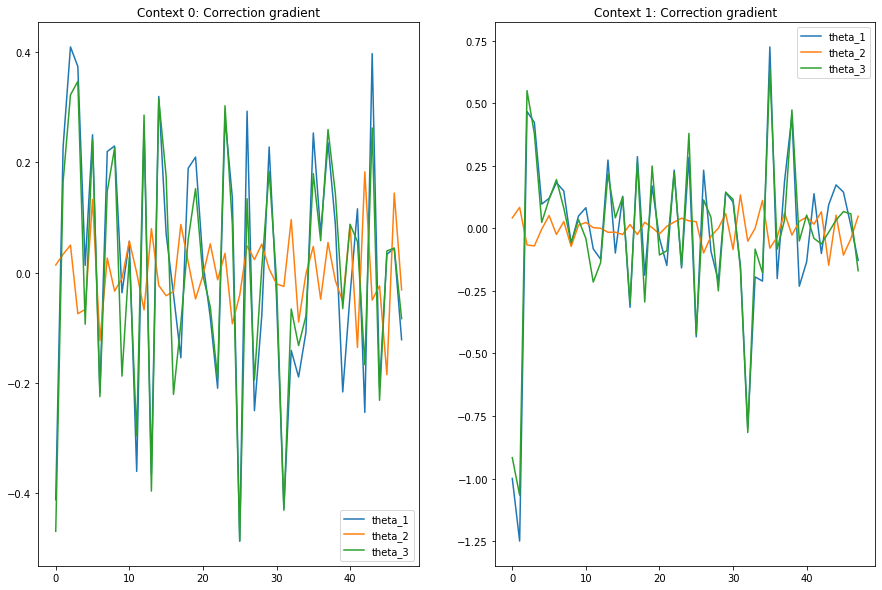

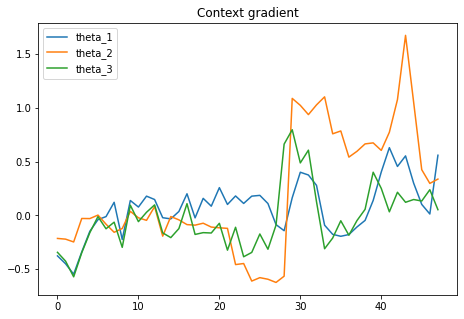

In [ ]:
start = timer()

md = Analytic2D(env, context_eta=CONTEXT_ETA,
                correction_eta=CORRECTION_ETA, context_theta_init=CONTEXT_THETA_INIT,
                correction_theta_init=CORRECTION_THETA_INIT)

episode_fidelity = []
control_fidelity = []

# "episodes" are a reasonable way to think about learning a periodic
# time-dependent function.
# max frames = episode length * num episodes
# episodes are identical sequences of training data
init_actions = md.get_actions(batch_size=BATCH_SIZE)
observation = env.reset(init_actions)

correction_2d_repr = {}
context_2d_repr = []

correction_grads = {}
context_grads = []

# context outcomes per episode
context_outcome_hist = {}

# Frames are given in terms of the number of epochs.
for frame_idx in range(1, MAX_FRAMES + 1):
    # An epoch is a predefined number of batches: (M // BATCH_SIZE)
    epoch = frame_idx // (M // BATCH_SIZE)

    # Mark:- beginning of main logic.
    # This will return the known optimal actions as a function of the context mapping.
    actions = md.get_actions(observation)
    prev_batch = env.error_samples_batch
    prev_observation = observation
    observation, feedback, done, info = env.step(actions)
    observation = None if done else observation

    for obs in prev_observation:
        context_outcome = 1 if np.sum(obs) > env.num_context_spectators / 2 else 0
        if epoch in context_outcome_hist.keys():
            context_outcome_hist[epoch].append(context_outcome)
        else:
            context_outcome_hist[epoch] = [context_outcome]

    md.update_correction_feedback(
              correction_feedback=feedback['batched_correction_feedback'],
              observations=prev_observation)
    md.update_context_feedback(context_feedback=feedback['batched_context_feedback'],
              observations=prev_observation)
    
    md.combine_correction_feedback()
    md.combine_contextual_feedback()
    # Mark:- end of main logic.

    for x, y in info:
        episode_fidelity.append(x)
        control_fidelity.append(y)

    if frame_idx % UPDATE_ERROR_SAMPLES_FRAMES == 0:
        new_error_samples = np.random.normal(MU, SIGMA, M)
        env.set_error_samples(new_error_samples)
        context_contour = get_contour(new_error_samples, context_loss)

    context_2d_repr.append(extract_theta_phi(
        env._get_correction(md.context_theta).dag()))
    for idx, c in enumerate(md.contexts):
        correction_2d = extract_theta_phi(
                env._get_correction(c.correction_theta).dag())
        if idx in correction_2d_repr.keys():
            correction_2d_repr[idx].append(correction_2d)
        else:
            correction_2d_repr[idx] = [correction_2d]

    correction_grad = [np.mean([a['correction_grad'] for a in np.array(actions)[[
                np.sum(obs) <= env.num_context_spectators / 2 for obs in prev_observation]]],
                    axis=0), np.mean([a['correction_grad'] for a in np.array(actions)[[
                np.sum(obs) > env.num_context_spectators / 2 for obs in prev_observation]]],
                    axis=0)]
    for i in range(2):
        if i in correction_grads.keys():
            correction_grads[i].append(correction_grad[i])
        else:
            correction_grads[i] = [correction_grad[i]]
    
    context_grads.append(np.mean([a['context_grad'] for a in np.array(actions)], axis=0))

    # All batches for episode complete.
    if done:
        md.save_fidelity(np.mean(episode_fidelity))
        md.save_control_fidelity(np.mean(control_fidelity))
        episode_fidelity = []
        control_fidelity = []

        correction_contour = {}
        correction_contour[0] = get_contour(prev_batch[
            [np.sum(obs) <= env.num_context_spectators / 2 for obs in prev_observation]], correction_loss)
        correction_contour[1] = get_contour(prev_batch[
            [np.sum(obs) > env.num_context_spectators / 2 for obs in prev_observation]], correction_loss)

        observation = env.reset(actions)

        clear_output(True)
        plot(frame_idx,
             timedelta(seconds=int(timer()-start)),
             baseline_fidelity=md.control_fidelity,
             corrected_fidelity=md.fidelity,
             context_theta_history=context_2d_repr,
             correction_theta_history=correction_2d_repr,
             correction_contour=correction_contour,
             context_outcome_hist=context_outcome_hist,
             context_contour=context_contour,
             correction_grads=correction_grads,
             context_grads=context_grads)
        plt.show()

env.close()



In [ ]:
# This is very slow. O(n^3) computation, for n=num_variational_params.
context_analytic_contour = get_analytic_contour(error_samples, num_variational_params=15)
print(len(context_analytic_contour['mesh_phi']))

In [ ]:
f, a = plt.subplots(1, 1, figsize=(7.5, 7.5), subplot_kw=dict(polar=True))
CS = a.contourf(context_analytic_contour['mesh_phi'], context_analytic_contour['mesh_theta'], context_analytic_contour['loss'])
a.scatter(x=[np.pi/2], y=[np.pi/2], label='ideal')
# a.clabel(CS, inline=True, fontsize=14, colors='r', manual=[(-np.pi/2, np.pi/2)])
a.legend()
a.set_title("True analytic context gradient magnitude")

cbar = f.colorbar(CS)
f.show()